In [110]:
# Import the necessary modules
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

In [35]:
df = pd.read_csv('Data/laptop_data.csv', index_col = 0)
display(df.head(2))
display(df.info())

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232


<class 'pandas.core.frame.DataFrame'>
Index: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   object 
 1   TypeName          1303 non-null   object 
 2   Inches            1303 non-null   float64
 3   ScreenResolution  1303 non-null   object 
 4   Cpu               1303 non-null   object 
 5   Ram               1303 non-null   object 
 6   Memory            1303 non-null   object 
 7   Gpu               1303 non-null   object 
 8   OpSys             1303 non-null   object 
 9   Weight            1303 non-null   object 
 10  Price             1303 non-null   float64
dtypes: float64(2), object(9)
memory usage: 122.2+ KB


None

Le jeu de données fourni contient 1303 observations réparties sur 11 variables, décrites comme suit :

    Company : le nom du fabricant de l'ordinateur (type : chaîne de caractères).
    TypeName : le type d'ordinateur (type : chaîne de caractères).
    Inches : la taille de l'écran de l'ordinateur en pouces (type : flottant).
    ScreenResolution : la résolution de l'écran (type : chaîne de caractères).
    Cpu : le processeur de l'ordinateur (type : chaîne de caractères).
    Ram : la capacité de mémoire vive (RAM) de l'ordinateur (type : chaîne de caractères).
    Memory : la capacité de stockage (mémoire) de l'ordinateur (type : chaîne de caractères).
    Gpu : la carte graphique de l'ordinateur (type : chaîne de caractères).
    OpSys : le système d'exploitation de l'ordinateur (type : chaîne de caractères).
    Weight : le poids de l'ordinateur en kilogrammes (type : chaîne de caractères).
    Price : le prix de l'ordinateur (type : flottant).

Cela constitue la structure de base de notre jeu de données.

<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Nettoyage et exploitation des données</p>

In [36]:
# identification of missing values
display(df.isna().sum())

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

On peut donc observer que notre jeu de données ne contient aucune valeur manquante pour aucune des variables. Cela signifie que toutes les observations sont complètes et qu'il n'est pas nécessaire de traiter des valeurs absentes avant d'analyser ou de modéliser les données.

In [37]:
# Transform 'Ram' to extract only the RAM size and convert it to an integer
df['Ram'] = df['Ram'].str[: -2].astype(int)  # Remove the last two characters (GB or MB) and convert to integer
# Transform 'Weight' to extract only the numeric value and convert it to float
df['Weight'] = df['Weight'].str[: -2].astype(float)  # Remove the last two characters (kg) and convert to float

# Extract the screen width from the 'ScreenResolution' column
df['Screen Width'] = df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[0].astype(int)  # Get width from resolution (e.g., "1920x1080" → "1920")
# Extract the screen height from the 'ScreenResolution' column
df['Screen Height'] = df['ScreenResolution'].str.split(' ').str[-1].str.split('x').str[1].astype(int)  # Get height from resolution (e.g., "1920x1080" → "1080")
df = df.drop('ScreenResolution', axis = 1)  # Drop the 'ScreenResolution' column

# Extract the CPU frequency and keep only the numeric value
df['Frequency'] = df['Cpu'].str.split(' ').str[-1]  # Get the last word (e.g., "3.5GHz")
# Remove the 'GHz' suffix and convert the frequency to a float
df['Frequency'] = df['Frequency'].str[: -3].astype(float)  # Remove the 'GHz' and convert to float

# Extract the CPU brand (first word)
df['Cpu Brand'] = df['Cpu'].str.split(' ').str[0]  # Get the first word (e.g., "Intel")
df = df.drop('Cpu', axis = 1)

# Extract the GPU brand (first word)
df['Gpu Brand'] = df['Gpu'].str.split(' ').str[0]  # Get the first word (e.g., "NVIDIA")
df = df.drop('Gpu', axis = 1)

# Split the 'Memory' column into 'Memory Size' and 'Memory Type'
df['Memory Size'] = df['Memory'].str.split(' ').str[0]  # Get the size part (e.g., "8GB")
df['Memory Type'] = df['Memory'].str.split(' ').str[1]  # Get the type part (e.g., "SSD")
df = df.drop('Memory', axis = 1)  # Drop the 'Memory' column
# Function to convert memory size to MB
def convert_into_MB(value):
    if 'GB' in value:
        return float(value.replace('GB', '').strip()) * 1024  # Convert GB to MB
    elif 'T' in value:
        return float(value.replace('TB', '').strip()) * 1048576  # Convert TB to MB
    else:
        return np.na  # Return NaN for unknown units
# Apply the conversion function to the 'Memory Size' column
df['Memory Size'] = df['Memory Size'].apply(convert_into_MB)  # Apply conversion to MB

df

,Company,TypeName,Inches,Ram,OpSys,Weight,Price,Screen Width,Screen Height,Frequency,Cpu Brand,Gpu Brand,Memory Size,Memory Type
0,Apple,Ultrabook,13.3,8,macOS,1.37,71378.6832,2560,1600,2.3,Intel,Intel,131072.0,SSD
1,Apple,Ultrabook,13.3,8,macOS,1.34,47895.5232,1440,900,1.8,Intel,Intel,131072.0,Flash
2,HP,Notebook,15.6,8,No OS,1.86,30636.0000,1920,1080,2.5,Intel,Intel,262144.0,SSD
3,Apple,Ultrabook,15.4,16,macOS,1.83,135195.3360,2880,1800,2.7,Intel,AMD,524288.0,SSD
4,Apple,Ultrabook,13.3,8,macOS,1.37,96095.8080,2560,1600,3.1,Intel,Intel,262144.0,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,33992.6400,1920,1080,2.5,Intel,Intel,131072.0,SSD
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,79866.7200,3200,1800,2.5,Intel,Intel,524288.0,SSD
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,12201.1200,1366,768,1.6,Intel,Intel,65536.0,Flash
1301,HP,Notebook,15.6,6,Windows 10,2.19,40705.9200,1366,768,2.5,Intel,AMD,1048576.0,HDD


In [38]:
# Dataset overview
df.describe()

,Inches,Ram,Weight,Price,Screen Width,Screen Height,Frequency,Memory Size
count,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1303.000000,1.303000e+03
mean,15.017191,8.382195,2.038734,59870.042910,1894.784344,1070.830391,2.298772,4.585571e+05
std,1.426304,5.084665,0.665475,37243.201786,494.641028,284.519410,0.506340,3.748221e+05
min,10.100000,2.000000,0.690000,9270.720000,1366.000000,768.000000,0.900000,8.192000e+03
25%,14.000000,4.000000,1.500000,31914.720000,1600.000000,900.000000,2.000000,2.621440e+05
50%,15.600000,8.000000,2.040000,52054.560000,1920.000000,1080.000000,2.500000,2.621440e+05
75%,15.600000,8.000000,2.300000,79274.246400,1920.000000,1080.000000,2.700000,5.242880e+05
max,18.400000,64.000000,4.700000,324954.720000,3840.000000,2160.000000,3.600000,2.097152e+06


D'après ce tableau, il est facile de constater qu'il n'y a pas de valeurs aberrantes. Les ordinateurs ayant une taille d'écran de 18 pouces peuvent être expliqués par le fait qu'il s'agit généralement d'ordinateurs de bureau, comme le montre une vérification sur Internet. Quant aux ordinateurs dont le prix dépasse les 324 954 euros, il s'agit principalement de modèles gaming, qui se caractérisent par une grande capacité de RAM, de mémoire et une fréquence élevée, entre autres spécificités.

<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Exploration et analyse des données</p>

Nous calculons la matrice de corrélation entre toutes les colonnes du DataFrame et la colonne 'Price'.

Cela permet de mettre en évidence les variables ayant une corrélation significative avec 'Price'.

In [54]:
limited_df = df.select_dtypes(include = 'number')
limited_df

,Inches,Ram,Weight,Price,Screen Width,Screen Height,Frequency,Memory Size
0,13.3,8,1.37,71378.6832,2560,1600,2.3,131072.0
1,13.3,8,1.34,47895.5232,1440,900,1.8,131072.0
2,15.6,8,1.86,30636.0000,1920,1080,2.5,262144.0
3,15.4,16,1.83,135195.3360,2880,1800,2.7,524288.0
4,13.3,8,1.37,96095.8080,2560,1600,3.1,262144.0
...,...,...,...,...,...,...,...,...
1298,14.0,4,1.80,33992.6400,1920,1080,2.5,131072.0
1299,13.3,16,1.30,79866.7200,3200,1800,2.5,524288.0
1300,14.0,2,1.50,12201.1200,1366,768,1.6,65536.0
1301,15.6,6,2.19,40705.9200,1366,768,2.5,1048576.0


La matrice de correlation

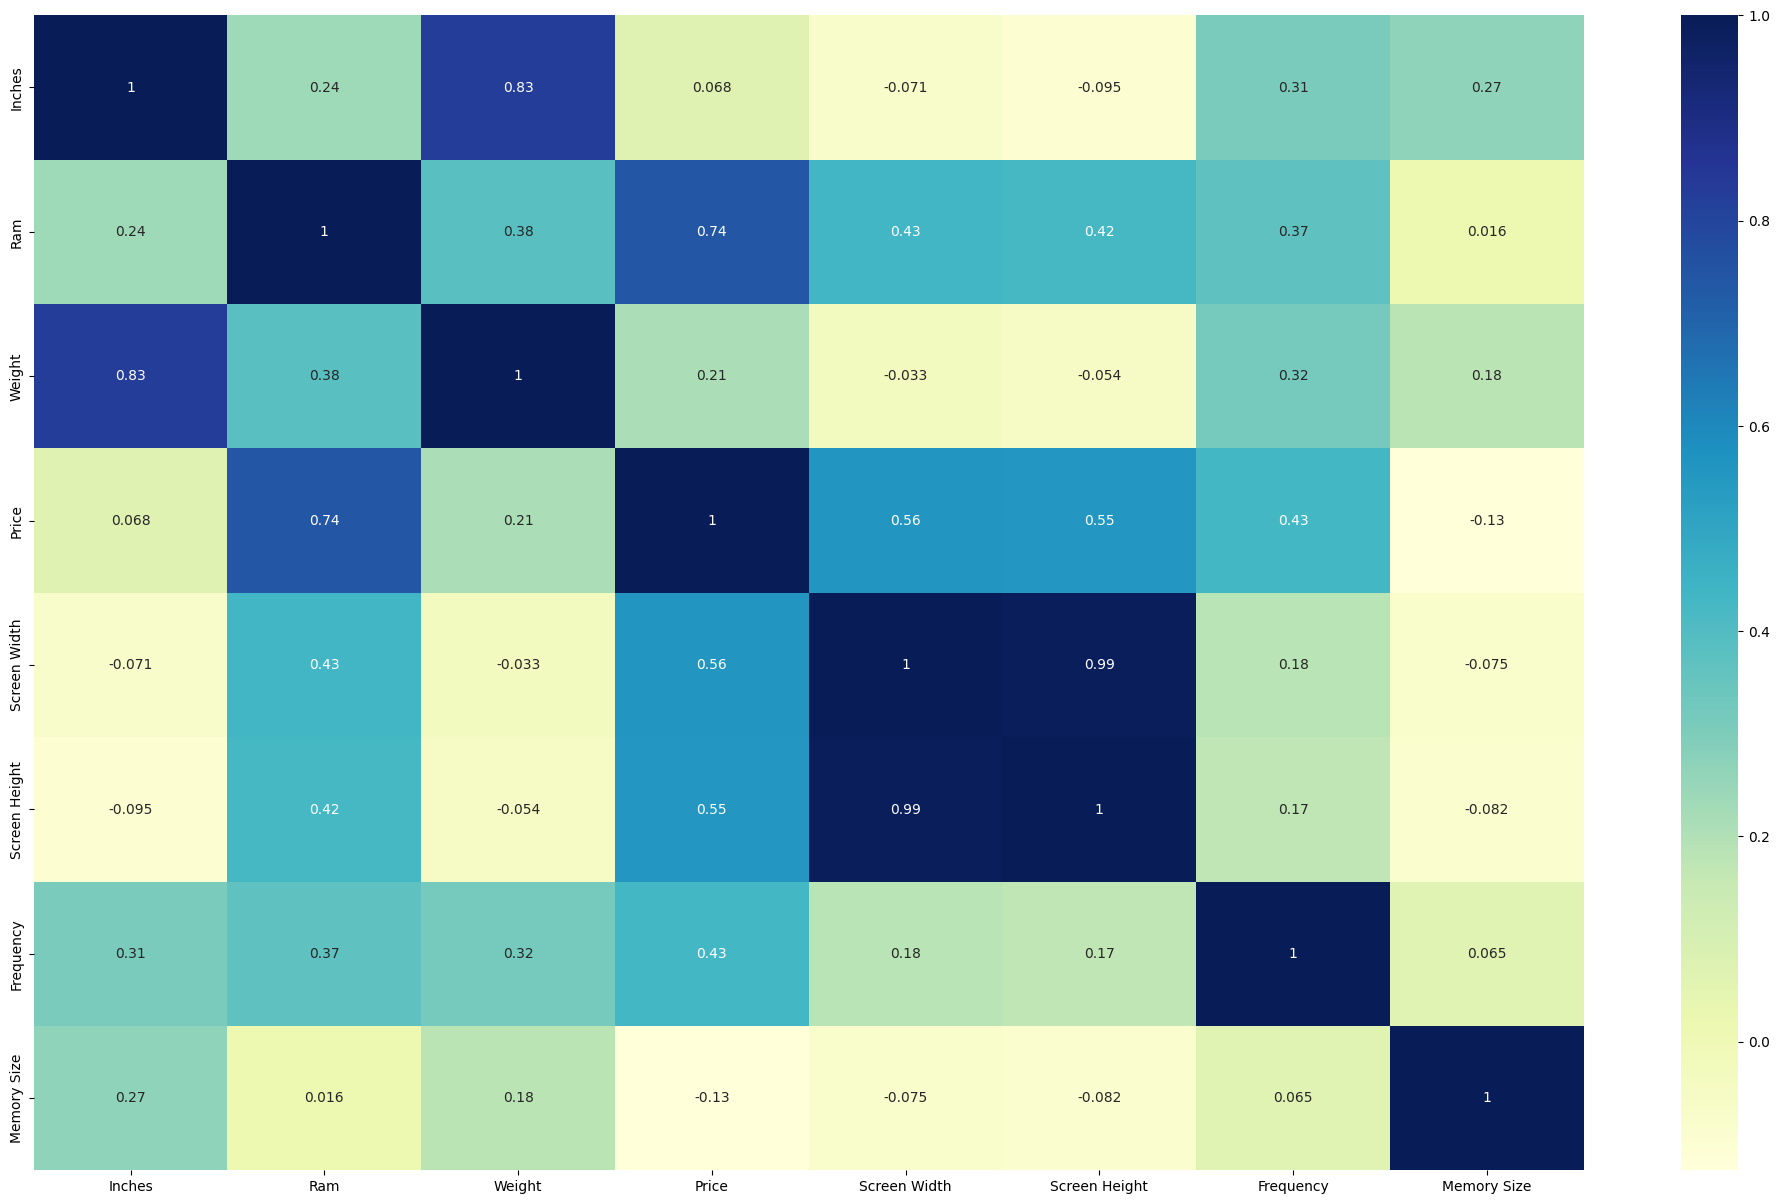

In [46]:
fig = plt.figure(figsize = (25, 15))
sns.heatmap(data = limited_df.corr(), annot = True, cmap = 'YlGnBu')
plt.show()

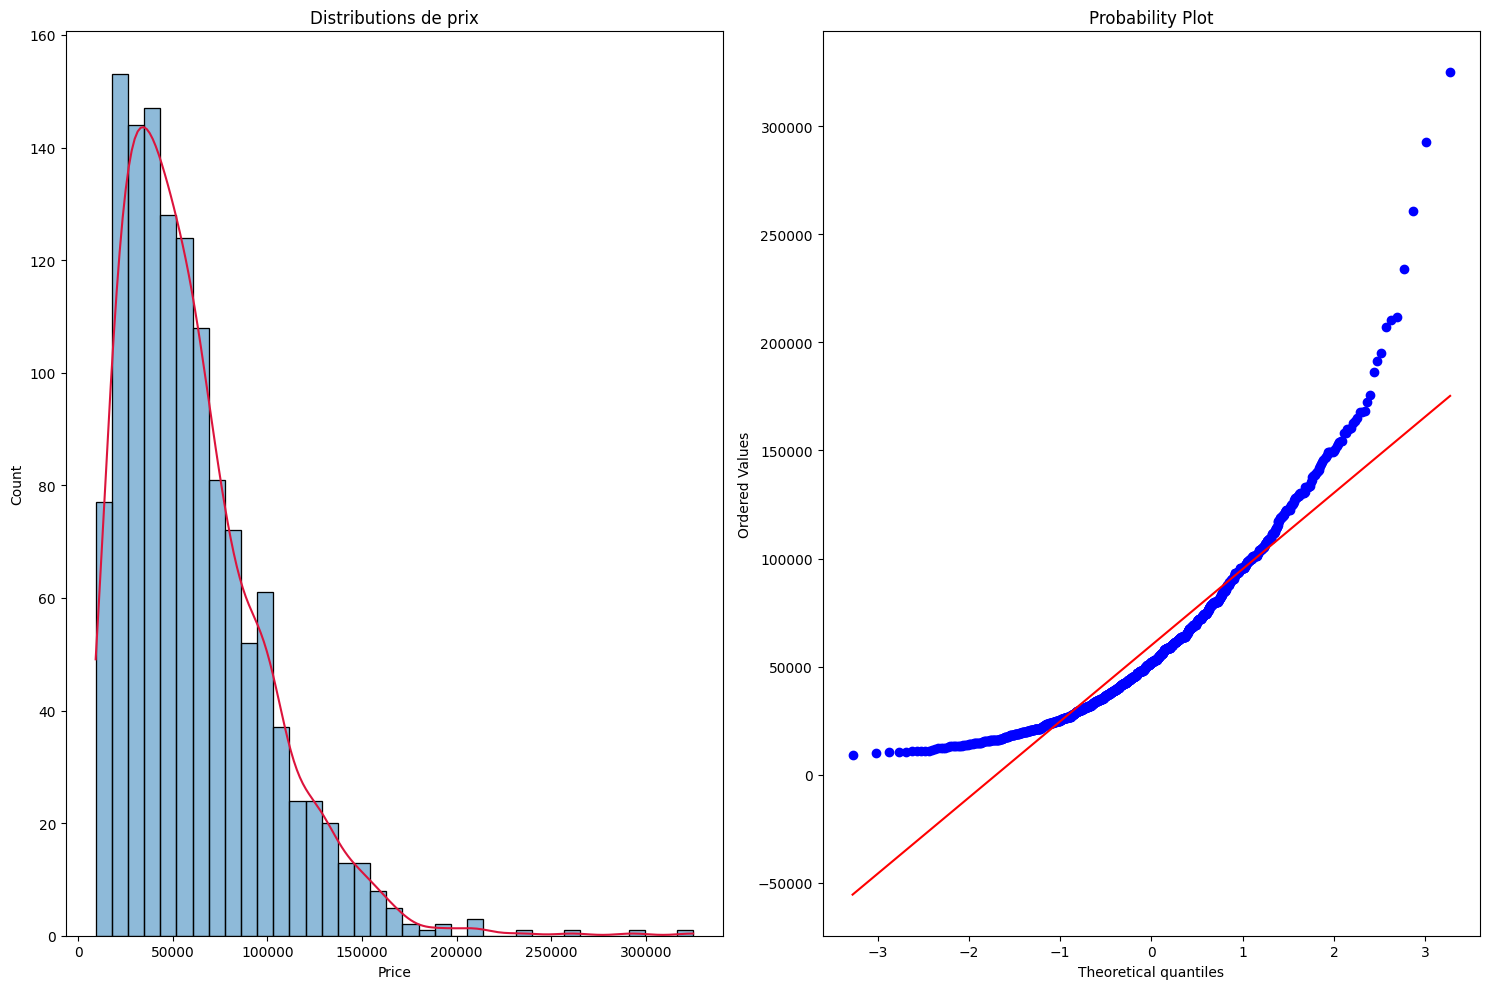

In [42]:
fig, axes = plt.subplots(1, 2, figsize = (15, 10))

sns.histplot(data = limited_df['Price'], kde = True, ax = axes[0])
axes[0].lines[0].set_color('crimson')
axes[0].set_title('Distributions de prix')

axes[1] = stats.probplot(limited_df['Price'], dist = 'norm', plot = plt)

plt.tight_layout()
plt.show()

Au vue de ces graphes ci-dessous, on dire que la distribution des prix d'ordinateurs ne suit pas une distrubition normale; que l'on va verifier grace a 
quelques tests tel que :
le coefficient de skewness : on sait que le coefficient de skewness (qui mesure la symetrie) d'une distribution normale est egal a 0
le coefficient de Kurtoisis : on sait que le coefficient de Kuroisis (qui mesure l'applatissement) d'une distribution normale est egal a 3

In [10]:
skewness = stats.skew(limited_df['Price'])
kurtoisis = stats.kurtosis(limited_df['Price'], fisher = False)
print(f'Le coefficient de skewness est egal a {skewness}')
print(f'Le coefficient de Kuroisis est egal a {kurtoisis}')

Le coefficient de skewness est egal a 1.5191142034364629
Le coefficient de Kuroisis est egal a 7.349729901222108


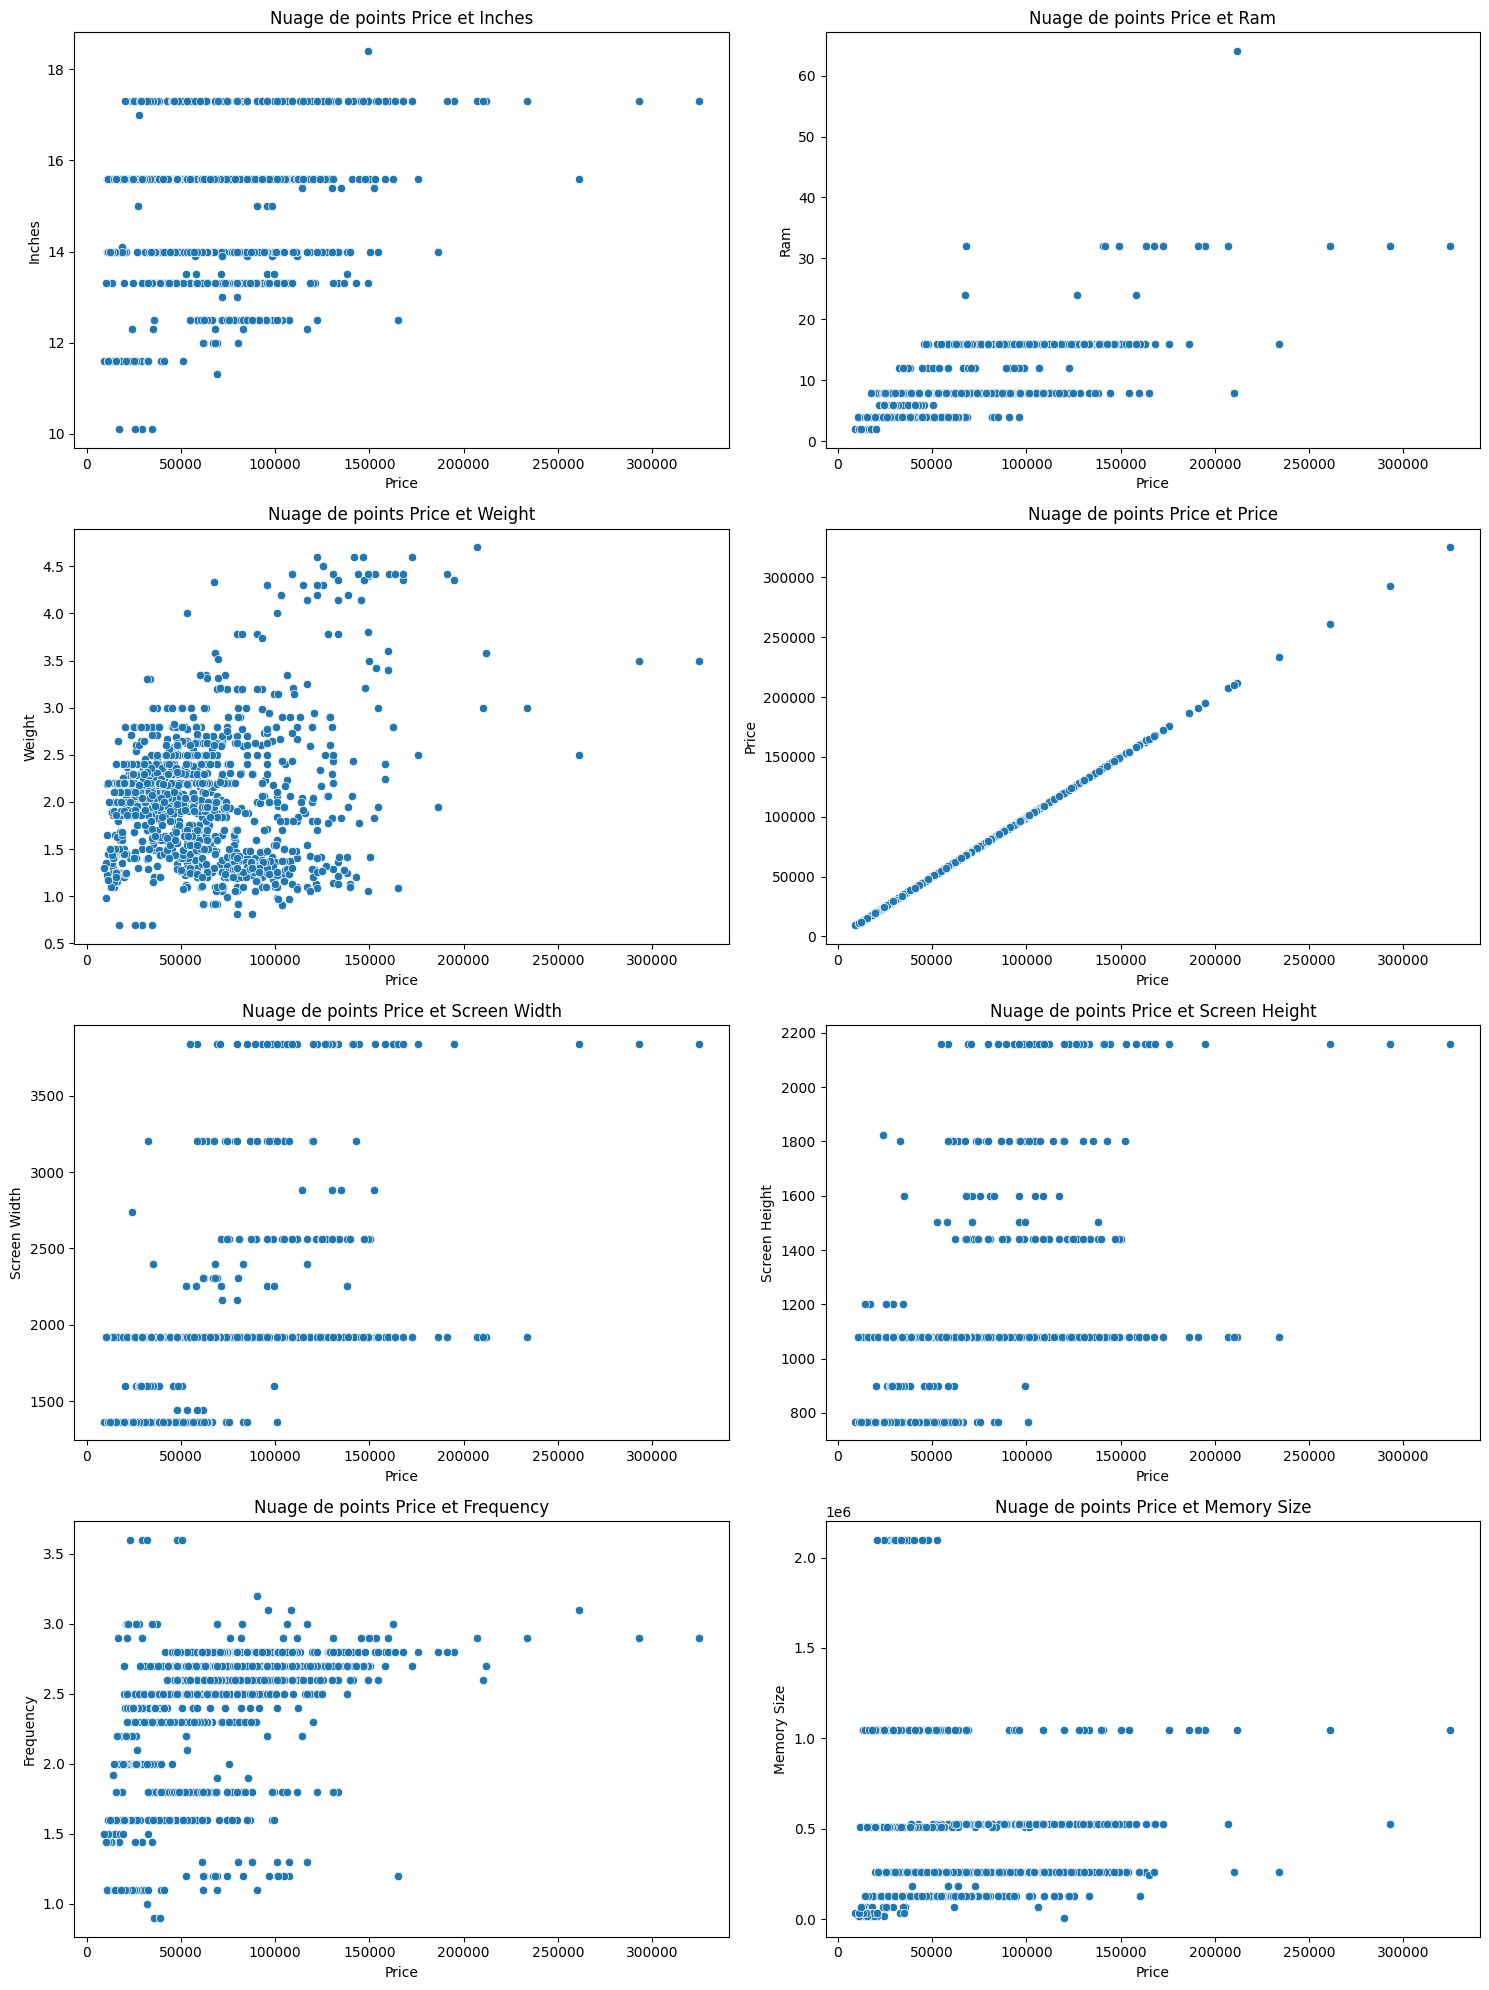

In [53]:
fig, axes = plt.subplots(4, 2, figsize = (15, 20))

for index, column in enumerate(limited_df.columns) :
    sns.scatterplot(data = limited_df, x = 'Price', y = column, ax = axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_title(f'Nuage de points Price et {column}')
    
plt.tight_layout()
plt.show()

Au vu de ces graphiques, il semble qu'aucune des variables caractéristiques (features) n'ait de relation linéaire évidente avec la variable cible, le prix. Cela suggère que les modèles linéaire pourraient ne pas être les mieux adaptés à ce problème. Cependant, il est possible d'explorer la relation entre les caractéristiques et la variable cible en utilisant des tests statistiques alternatifs, tels que le test de Shapiro, qui permet de vérifier la normalité des variables à l'aide de la p-value.

In [47]:
for column in limited_df.columns :
    _, p_value = stats.shapiro(limited_df[column])
    if p_value < 0.05 :
        print(f'P-value de la  normalité (Shapiro-wilk) pour la variable {column} est : {p_value}')

P-value de la  normalité (Shapiro-wilk) pour la variable Inches est : 6.810711858612796e-31
P-value de la  normalité (Shapiro-wilk) pour la variable Ram est : 1.9729656813867227e-42
P-value de la  normalité (Shapiro-wilk) pour la variable Weight est : 1.2811032902304129e-25
P-value de la  normalité (Shapiro-wilk) pour la variable Price est : 4.688363475796598e-29
P-value de la  normalité (Shapiro-wilk) pour la variable Screen Width est : 7.906567027465655e-46
P-value de la  normalité (Shapiro-wilk) pour la variable Screen Height est : 2.2892835167881434e-45
P-value de la  normalité (Shapiro-wilk) pour la variable Frequency est : 2.791801467001679e-29
P-value de la  normalité (Shapiro-wilk) pour la variable Memory Size est : 9.076493540793472e-39


Au vu des valeurs p-value des différentes variables, on peut aisément rejeter l'hypothèse selon laquelle elles suivent une distribution normale, 
car ces p-values sont inférieures au seuil de significativité de 0,05. 
Cependant, il est possible d'examiner s'il existe une relation monotone forte entre ces variables et la variable cible en utilisant le test de Spearman.

In [51]:
for column in limited_df.columns :
    _, p_value = stats.spearmanr(limited_df['Price'], limited_df[column])
    if p_value < 0.05 :
        print(f'Il y\' a une forte relation monotone entre la variable Price et {column} car p-value = {p_value}')
    else :
        print(f'Il n\'y a pas de relation monotone forte entre la variable Price et {column} car p-value = {p_value}')

Il n'y a pas de relation monotone forte entre la variable Price et Inches car p-value = 0.0916405621260066
Il y' a une forte relation monotone entre la variable Price et Ram car p-value = 2.227782211034968e-255
Il n'y a pas de relation monotone forte entre la variable Price et Weight car p-value = 0.3904266279447126
Il y' a une forte relation monotone entre la variable Price et Price car p-value = 0.0
Il y' a une forte relation monotone entre la variable Price et Screen Width car p-value = 2.9180606434221587e-147
Il y' a une forte relation monotone entre la variable Price et Screen Height car p-value = 2.6065065003868453e-141
Il y' a une forte relation monotone entre la variable Price et Frequency car p-value = 2.171205826040976e-94
Il n'y a pas de relation monotone forte entre la variable Price et Memory Size car p-value = 0.274482290112127


<p style = 'text-align : center; font-weight : bold; font-size : 24px; color : dodgerblue;'>Entraînement et
validation de modèles</p>

In [111]:
X, y = limited_df.drop('Price', axis = 1), limited_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, test_size = 0.30, random_state = 42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [112]:
models = {
    'reg' : LinearRegression(),
    'forest' : RandomForestRegressor(),
    'ridge' : Ridge(),
    'lasso' : Lasso()
}
for model_name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    r_squared = r2_score(y_test, y_pred)
    print(f'R^2 score pour le modèle {model_name} est : {r_squared}')

R^2 score pour le modèle reg est : 0.6530267598350998
R^2 score pour le modèle forest est : 0.7214355050758663
R^2 score pour le modèle ridge est : 0.652957199018634
R^2 score pour le modèle lasso est : 0.6529882867348766


In [113]:
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

feature_importances = model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature' : features,
    'Importance' : feature_importances
})
importance_df = importance_df.sort_values(by = 'Importance', ascending = False)
importance_df

,Feature,Importance
1,Ram,0.567070
2,Weight,0.168859
5,Frequency,0.113692
6,Memory Size,0.050988
0,Inches,0.036793
3,Screen Width,0.033651
4,Screen Height,0.028946


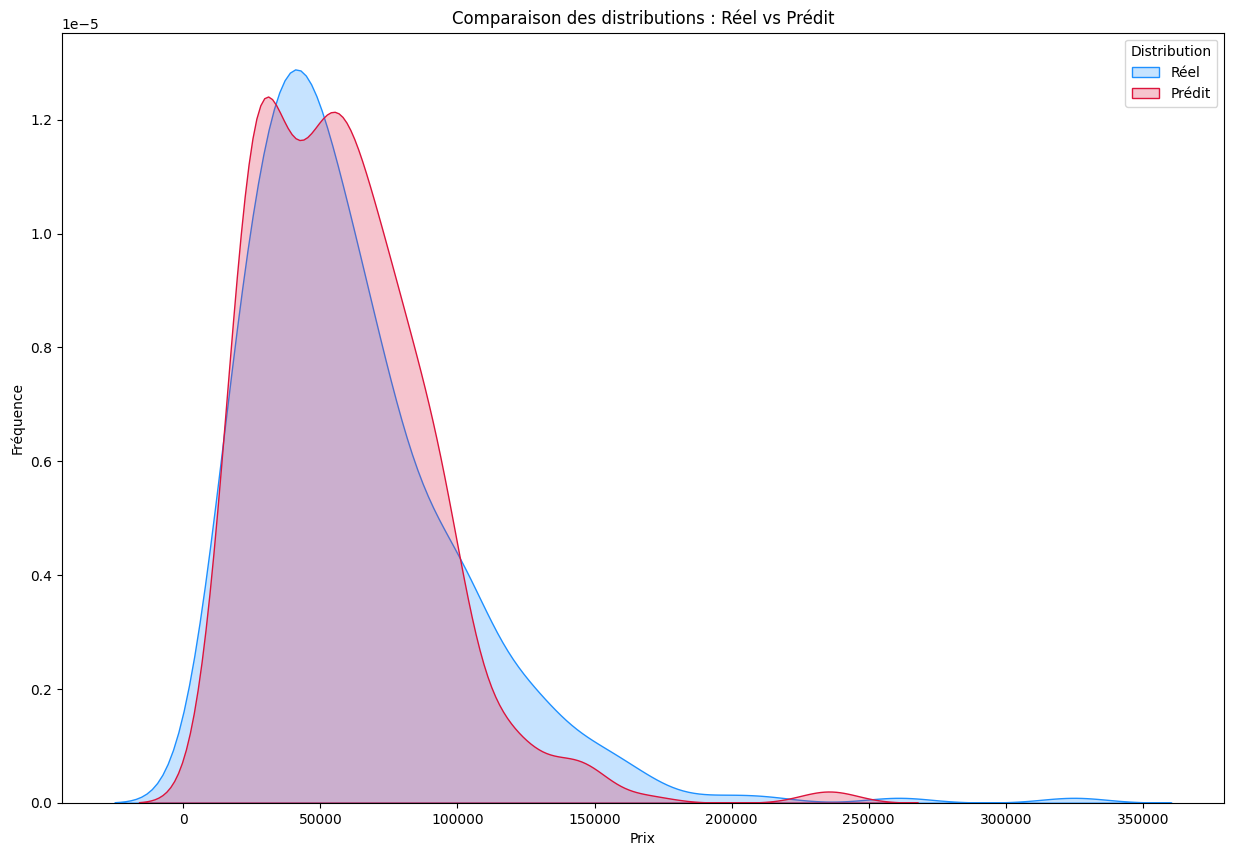

In [118]:
fig = plt.figure(figsize = (15, 10))
sns.kdeplot(y_test, color = 'dodgerblue', label = 'Réel', fill = True)
sns.kdeplot(y_pred, color = 'crimson', label = 'Prédit', fill = True)
plt.title('Comparaison des distributions : Réel vs Prédit')
plt.xlabel('Prix')
plt.ylabel('Fréquence')
plt.legend(title = 'Distribution')
plt.show()

In [122]:
new_data = {
    'Inches' : [13.3],
    'Ram' : [8],
    'Weight' : [1.3],
    'Screen Width' : [2560],
    'Screen Height' : [1600],
    'Frequency' : [2.4],
    'Memory Size' : [131072.0]
}
new_data = pd.DataFrame(new_data)
new_data_scaled = scaler.transform(new_data)
predicted_price = model.predict(new_data_scaled)
print(f"Le prix prédit est : {predicted_price[0]}")

Le prix prédit est : 73788.26587199993


In [125]:
joblib.dump(model, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [126]:
loaded_model = joblib.load('random_forest_model.joblib')
predicted_price = loaded_model.predict(new_data_scaled)
print(f"Le prix prédit est : {predicted_price[0]}")

Le prix prédit est : 73788.26587199993
